# Load data

In [1]:
from lib.eval.regression import normalize
from lib.zero_shot import get_gap_ids
import os
import numpy as np
seed = 123
rng = np.random.RandomState(seed)

# setup
data_dir = 'data/' 
codes_dir = os.path.join(data_dir, 'codes/')

n_c = 6 # num code variables
zshot = True

model_names = ['PCA', 'InfoGAN']
n_models = len(model_names)
train_fract, dev_fract, test_fract = 0.8, 0.1, 0.1
#exp_names = ["{0}_{1}_{2}v".format(m.lower(), zshot, n_c) for m in model_names]
exp_names = ["pca_True_6v", "infogan_True_6v"]

# load inputs (model codes)
m_codes = []
for n in exp_names:
    try:
        m_codes.append(np.load(os.path.join(codes_dir, n + '.npy')))
    except IOError:
        # .npz, e.g. pca with keys: codes, explained_variance
        m_codes.append(np.load(os.path.join(codes_dir, n + '.npz'))['codes'])

# load targets (groundtruths)
gts = np.load(os.path.join(data_dir, 'teapots.npz'))['gts']
n_samples = gts.shape[0]
n_z = gts.shape[1] #num gen factors
n_train, n_dev, n_test = int(train_fract*n_samples), int(dev_fract*n_samples), int(test_fract*n_samples)

# create 'gap' in data if zeroshot (unseen factor combinations)
if zshot:
    try:
        gap_ids = np.load(os.path.join(data_dir, 'gap_ids.npy'))
    except IOError:
        gap_ids = get_gap_ids(gts)
    def create_gap(data):
        return np.delete(data, gap_ids, 0)
    
# split inputs and targets into sets: [train, dev, test, (zeroshot)]
def split_data(data):
    train = data[:n_train]
    dev = data[n_train: n_train + n_dev]
    test = data[n_train + n_dev: n_train + n_dev + n_test]
    if zshot:
        return [create_gap(train), create_gap(dev), create_gap(test), data[gap_ids]]
    return [train, dev, test, None]

gts = split_data(gts)
for i in range(n_models):
    m_codes[i] = split_data(m_codes[i])    

# normalize input and target datasets [train, dev, test, (zeroshot)]
def normalize_datasets(datasets):
    datasets[0], mean, std, _ = normalize(datasets[0], remove_constant=False)
    datasets[1], _, _, _ = normalize(datasets[1], mean, std, remove_constant=False)
    datasets[2], _, _, _ = normalize(datasets[2], mean, std, remove_constant=False)
    if zshot:
        datasets[3], _, _, _ = normalize(datasets[3], mean, std, remove_constant=False)
    return datasets

gts = normalize_datasets(gts)
for i in range(n_models):
    m_codes[i] = normalize_datasets(m_codes[i])

# Regression

### Fit regressor, visualise and quantify criteria

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from lib.eval.hinton import hinton
from lib.eval.regression import *

def fit_visualise_quantify(regressor, params, err_fn, importances_attr, test_time=False):
    # lists to store scores
    m_disent_scores   = [] * n_models
    m_complete_scores = [] * n_models
    
    # arrays to store errors (+1 for avg)
    train_errs = np.zeros((n_models, n_z + 1))
    dev_errs   = np.zeros((n_models, n_z + 1))
    test_errs  = np.zeros((n_models, n_z + 1)) 
    zshot_errs = np.zeros((n_models, n_z + 1))
    
    # init plot (Hinton diag)
    fig, axs = plt.subplots(1,n_models, figsize=(7, 5), facecolor='w', edgecolor='k')
    fig.tight_layout(w_pad=2.0)
    axs = axs.ravel()
    
    for i in range(n_models):
        # init inputs
        X_train, X_dev, X_test, X_zshot = m_codes[i][0], m_codes[i][1], m_codes[i][2], m_codes[i][3]
           
        # R_ij = relative importance of c_i in predicting z_j
        R = [] 
        
        for j in range(n_z):
            # init targets [shape=(n_samples, 1)]
            y_train = gts[0][:, j]
            y_dev   = gts[1][:, j]
            y_test  = gts[2][:, j] if test_time else None
            y_zshot = gts[3][:, j] if zshot else None
            
            # fit model
            model = regressor(**params[i][j])
            model.fit(X_train, y_train)

            # predict
            y_train_pred = model.predict(X_train)
            y_dev_pred   = model.predict(X_dev)
            y_test_pred  = model.predict(X_test) if test_time else None
            y_zshot_pred = model.predict(X_zshot) if zshot else None
            
            # calculate errors
            train_errs[i, j] = err_fn(y_train_pred, y_train)
            dev_errs[i, j]   = err_fn(y_dev_pred, y_dev)
            test_errs[i, j]  = err_fn(y_test_pred, y_test) if test_time else None
            zshot_errs[i, j] = err_fn(y_zshot_pred, y_zshot) if zshot else None            
            
            # extract relative importance of each code variable in predicting z_j
            r = getattr(model, importances_attr)[:, None] # [n_c, 1]
            R.append(r)

        R = np.hstack(R)

        # disentanglement
        disent_scores = entropic_scores(R.T)
        c_rel_importance = np.sum(R,1) / np.sum(R) # relative importance of each code variable
        disent_w_avg = np.sum(np.array(disent_scores) * c_rel_importance)
        disent_scores.append(disent_w_avg)
        m_disent_scores.append(disent_scores)

        # completeness
        complete_scores = entropic_scores(R)
        complete_avg = np.mean(complete_scores)
        complete_scores.append(complete_avg)
        m_complete_scores.append(complete_scores)

        # informativeness (append averages)
        train_errs[i, -1] = np.mean(train_errs[i, :-1])
        dev_errs[i, -1]   = np.mean(dev_errs[i, :-1])
        test_errs[i, -1]  = np.mean(test_errs[i, :-1]) if test_time else None
        zshot_errs[i, -1] = np.mean(zshot_errs[i, :-1]) if zshot else None

        # visualise
        hinton(R, '$\mathbf{z}$', '$\mathbf{c}$', ax=axs[i], fontsize=18)
        axs[i].set_title('${0}$'.format(model_names[i]), fontsize=20)

    plt.show()

    print_table_pretty('Disentanglement', m_disent_scores, 'c', model_names)
    print_table_pretty('Completeness', m_complete_scores, 'z', model_names)

    print("Informativeness:")
    
    print_table_pretty('Training Error', train_errs, 'z', model_names)
    print_table_pretty('Validation Error', dev_errs, 'z', model_names)
    
    if test_time:
        print_table_pretty('Test Error', test_errs, 'z', model_names)
        if zshot:
            print_table_pretty('Zeroshot Error', zshot_errs, 'z', model_names)

### Lasso

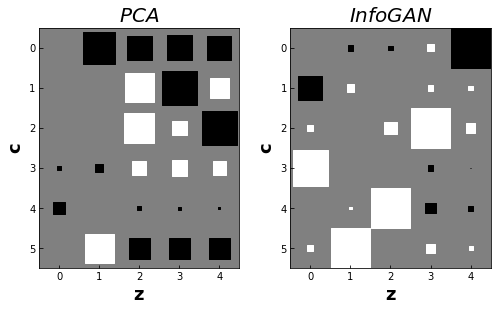

Disentanglement:
	c0	c1	c2	c3	c4	c5	Avg.
PCA	0.16&	0.38&	0.42&	0.14&	0.63&	0.16&	0.20&	
InfoGAN	0.83&	0.64&	0.65&	0.93&	0.79&	0.79&	0.77&	

Completeness:
	z0	z1	z2	z3	z4	Avg.
PCA	0.83&	0.54&	0.14&	0.20&	0.19&	0.38&	
InfoGAN	0.56&	0.85&	0.80&	0.63&	0.78&	0.72&	

Informativeness:
Training Error:
	z0	z1	z2	z3	z4	Avg.
PCA	0.99&	0.51&	0.35&	0.35&	0.35&	0.51&	
InfoGAN	0.49&	0.09&	0.09&	0.13&	0.09&	0.18&	

Validation Error:
	z0	z1	z2	z3	z4	Avg.
PCA	0.99&	0.52&	0.36&	0.35&	0.35&	0.51&	
InfoGAN	0.50&	0.09&	0.09&	0.13&	0.09&	0.18&	



In [8]:
from sklearn.linear_model import Lasso

alpha = 0.015
params = [[{"alpha": alpha}] * n_z] * n_models # constant alpha for all models and targets
importances_attr = 'coef_' # i.e. weights
err_fn = nrmse #norm root mean sq. error

fit_visualise_quantify(Lasso, params, err_fn, importances_attr)

### Random Forest

In [ ]:
from sklearn.ensemble.forest import RandomForestRegressor

n_estimators = 10
all_best_depths = [[14, 10, 10, 10, 10] , [12, 10, 10, 10, 10]]

# populate params dict with best_depths per model per target (z gt)
params = [[]] * n_models
for i, z_max_depths in enumerate(all_best_depths):
    for z_max_depth in z_max_depths:
        params[i].append({"n_estimators":n_estimators, "max_depth":z_max_depth, "random_state": rng})

importances_attr = 'feature_importances_'
err_fn = nrmse #norm root mean sq. error

fit_visualise_quantify(RandomForestRegressor, params, err_fn, importances_attr)